In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
from torch.optim import LBFGS
import matplotlib.pyplot as plt
from tqdm import trange

from IPython.display import clear_output

from steganogan import SteganoGAN
from rnns import BasicDecoder, shuffle_params, load_image_and_target, save_image

In [3]:
num_bits = 1
hidden_size = 128
pretrained = False
pretrained_path = None
flatten_image = False

criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')

steps = 2000
max_iter = 20
lr = 0.1
eps = 0.105

img_path = "./data/img.png"

In [4]:
if pretrained:
    steganogan = SteganoGAN.load(path=pretrained_path, cuda=True, verbose=True)
    model = steganogan.decoder
else:
    model = BasicDecoder(num_bits, hidden_size, flatten_image)
print(model)

BasicDecoder(
  (layers): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01, inplace)
    (2): normLayer()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.01, inplace)
    (5): normLayer()
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.01, inplace)
    (8): normLayer()
    (9): Conv2d(128, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)


image: torch.Size([1, 3, 225, 300]), target: torch.Size([1, 1, 225, 300])


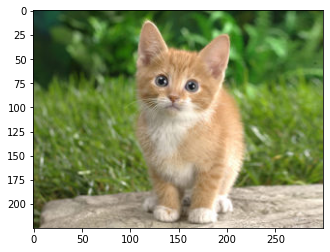

In [5]:
image, target = load_image_and_target(img_path, num_bits, flatten_image)
model.apply(shuffle_params)
model.to('cuda')

print(f"image: {image.shape}, target: {target.shape}")
plt.imshow(image.cpu().numpy()[0].transpose(1, 2, 0))

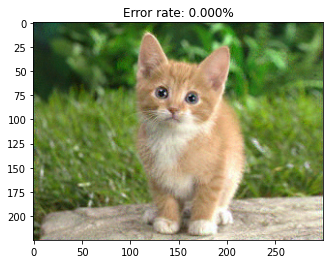

 30%|███       | 30/100 [00:25<01:00,  1.16it/s]


In [6]:
_eps = eps-0.0005
adv_image = image.clone().detach()

for i in trange(steps // max_iter):
#     print(i)
    adv_image.requires_grad = True
    optimizer = LBFGS([adv_image], lr=lr, max_iter=max_iter)

    def closure():
        outputs = model(adv_image)
        loss = criterion(outputs, target)

        optimizer.zero_grad()
        loss.backward()
        return loss

    optimizer.step(closure)
    delta = torch.clamp(adv_image - image, min=-_eps, max=_eps)
    adv_image = torch.clamp(image + delta, min=0, max=1).detach()

    err = len(torch.nonzero((model(adv_image)>0).float().view(-1) != target.view(-1))) / target.numel()
    
    clear_output(wait=True)
    plt.imshow(adv_image.cpu().numpy()[0].transpose(1, 2, 0))
    plt.title(f"Error rate: {err*100:0.3f}%")
    plt.show()
    if err == 0:
        break

In [7]:
save_image(adv_image, "./img_out.png")

image has been saved to ./img_out.png
